# The Dining Problem

_Will Kaufman, Ivy Yan_

May 28, 2021

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# The problem

Here's the simplest case: each night a student decides where to eat dinner. She has a choice of $n$ dining venues and is indifferent between all of them. However, she is busy and wants to minimize the time she waits for food. If the wait time $t_W^{(i)}$ at venue $i$ follows a Poisson distribution with unknown parameter $\lambda_i$
$$
t_W^{(i)} \sim \text{Pois}(\lambda_i)
$$
what strategy would minimize the student's wait time for meals?

This formulation is exactly a multi-armed bandit problem.

# Multi-armed bandits

@thompson1933likelihood, @thompson1934, @robbins1952some

Describe multi-armed bandits, cite stuff

# Greedy policy

# The Dining Problem

_Will Kaufman, Ivy Yan_

May 28, 2021

# The problem

Here's the simplest case: each night a student decides where to eat dinner. She has a choice of $n$ dining venues and is indifferent between all of them. However, she is busy and wants to minimize the time she waits for food. If the wait time $t_W^{(i)}$ at venue $i$ follows a Poisson distribution with unknown parameter $\lambda_i$
$$
t_W^{(i)} \sim \text{Pois}(\lambda_i)
$$
what strategy would minimize the student's wait time for meals?

This formulation is exactly a multi-armed bandit problem.

# Multi-armed bandits

Describe multi-armed bandits, cite stuff

# O-week, then get lazy

In [100]:
lambdas = np.array([4, 5, 6])

In [101]:
wait_times = np.random.poisson(lam=lam, size=(70*3, lam.size))

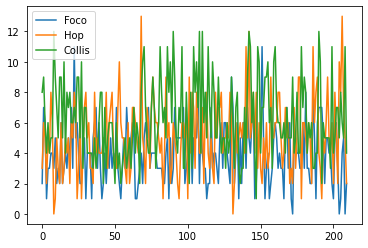

In [102]:
plt.plot(wait_times[:, 0], label='Foco')
plt.plot(wait_times[:, 1], label='Hop')
plt.plot(wait_times[:, 2], label='Collis')
plt.legend()

In [103]:
random_picks = np.random.randint(3, size=(14,))
random_picks = np.eye(3, dtype=int)[random_picks]

In [104]:
chosen_wait_times = wait_times[:14, :] * random_picks

In [105]:
Q_estimate = chosen_wait_times.sum(axis=0) / random_picks.sum(axis=0)

In [106]:
Q_estimate

array([4.75, 3.4 , 8.4 ])

In [107]:
remaining_wait_times = wait_times[14:, Q_estimate.argmin()]

In [108]:
cum_wait_time = np.concatenate(
    [chosen_wait_times.sum(axis=1),
     remaining_wait_times],
    axis=0
).cumsum()

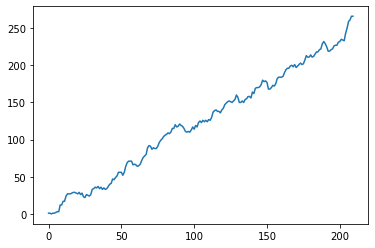

In [109]:
plt.plot(cum_wait_time - wait_times[:, lambdas.argmin()].cumsum())

# Greedy policy

In [110]:
lambdas = np.array([4, 5, 6])

In [111]:
wait_times = np.random.poisson(lam=lam, size=(70*3, lam.size))

In [126]:
# plt.plot(wait_times[:, 0], label='Foco')
# plt.plot(wait_times[:, 1], label='Hop')
# plt.plot(wait_times[:, 2], label='Collis')
# plt.legend()

In [129]:
N = np.zeros((3,))
Q_estimate = np.zeros((3,))
actions = np.zeros((wait_times.shape[0],), dtype=int)

In [130]:
for i in range(wait_times.shape[0]):
    a = Q_estimate.argmin()
    actions[i] = a
    w = wait_times[i, a]
    N[a] += 1
    Q_estimate[a] = Q_estimate[a] + 1/N[a]*(w - Q_estimate[a])

In [125]:
Q_estimate

array([4.10576923, 6.        , 5.        ])

In [139]:
N

array([208.,   1.,   1.])

In [140]:
(N * Q_estimate).sum() - (wait_times[:, lambdas.argmin()]).sum()

1.999999999999659

In [141]:
extra_time = np.zeros((1000,))

In [142]:
for _ in range(1000):
    wait_times = np.random.poisson(lam=lam, size=(70*3, lam.size))
    N = np.zeros((3,))
    Q_estimate = np.zeros((3,))
    actions = np.zeros((wait_times.shape[0],), dtype=int)
    for i in range(wait_times.shape[0]):
        a = Q_estimate.argmin()
        actions[i] = a
        w = wait_times[i, a]
        N[a] += 1
        Q_estimate[a] = Q_estimate[a] + 1/N[a]*(w - Q_estimate[a])
    extra_time[_] = (N * Q_estimate).sum() - (wait_times[:, lambdas.argmin()]).sum()

(array([785.,  17.,  11.,  57.,  69.,  34.,   6.,  14.,   4.,   3.]),
 array([-12. ,  40.2,  92.4, 144.6, 196.8, 249. , 301.2, 353.4, 405.6,
        457.8, 510. ]),
 <BarContainer object of 10 artists>)

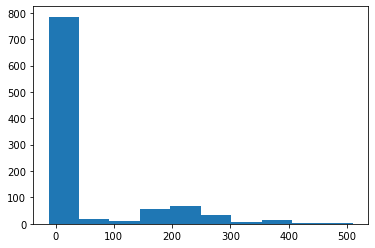

In [144]:
plt.hist(extra_time)

# $\epsilon$-greedy policy

# Upper confidence bound (UCB) policy

# What these look like for the dining problem

- Descriptions, feasibility
- Simulations

# Relaxing assumptions

- Non-stationary distributions (different terms -> different people on campus -> different wait times)
- 